# Initialization

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch import distributions, optim
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Mounted at /content/drive
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..


In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

# Optimization Settings

In [5]:
observation = 'hospitalization' # 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 1
# Overall Time Period
start_time='2020-08-01'
end_time='2021-02-01'

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

# Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.0,64.0,4.0
1,2020-08-02,0.0,78.0,2.0
2,2020-08-03,0.0,117.0,7.0


# Experiments to determine Model Parameter

In [ ]:
no_experiments = 10
epochs = 1000
list_R0 = []
list_sigma = []
list_phi = []
list_alpha = []

In [36]:
for n in range(no_experiments):
  print('Starting Experiment ' + str(n))
  # Initialize
  cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
  method = RandomWalk(n_observations = df_obs.shape[0], device=device, dtype=dtype)
  dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
  
  params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
  if observation == 'hospitalization':
    params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

  optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
  scheduler = ExponentialLR(optimizer, gamma=0.999)
  
  for i in range(epochs):
    iteration_time = time.time()
    optimizer.zero_grad()

    # transform alphi, phi
    dict_param = transform_prime_variables(dict_param)


    # forward pass
    expected = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
    
    # calc loss
    comparison_loss =  calc_mse(expected, observed) * dict_param['real_values']['phi'] # calc_poisson_loss(expected, observed) * dict_param['real_values']['phi'] #
    method_loss = method.calculate_loss() 
    model_param_loss = calc_prior_loss(dict_param, device, dtype)
    loss = comparison_loss + method_loss + model_param_loss

    # backward pass
    loss.backward()
    optimizer.step()
    scheduler.step()


  # Save model parameter
  list_R0.append(method.get_R0().item())
  list_sigma.append(method.get_sigma().item())
  list_phi.append(dict_param['real_values']['phi'].item())
  list_alpha.append(dict_param['real_values']['alpha'].item())

Starting Experiment 0
Starting Experiment 1
Starting Experiment 2
Starting Experiment 3
Starting Experiment 4
Starting Experiment 5
Starting Experiment 6
Starting Experiment 7


ValueError: ignored

# Visualize Experiment Results

In [37]:
iterations = np.arange(len(list_R0))
df_results = pd.DataFrame()
df_results['iteration'] = iterations
df_results['R0'] = list_R0
df_results['sigma'] = list_sigma
df_results['phi'] = list_phi
df_results['alpha'] = list_alpha
df_results.head()

,iteration,R0,sigma,phi,alpha
0,0,1.668548,0.031084,24.723875,0.031449
1,1,1.714489,0.032436,24.733404,0.027886
2,2,1.680202,0.030756,24.713810,0.029397
3,3,1.532284,0.045014,24.586308,0.049860
4,4,1.500000,0.097447,25.000000,0.028000


In [45]:
df_results.describe()

,iteration,R0,sigma,phi,alpha
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,19.500000,1.571600,0.073075,24.769347,0.023388
std,11.690452,0.153347,0.036401,0.226276,0.012662
min,0.000000,1.453034,0.027902,24.211750,0.003431
25%,9.750000,1.477082,0.032349,24.637022,0.010001
50%,19.500000,1.500000,0.090955,24.726396,0.028000
75%,29.250000,1.610342,0.098422,24.974582,0.029361
max,39.000000,2.045553,0.189855,25.000000,0.049860


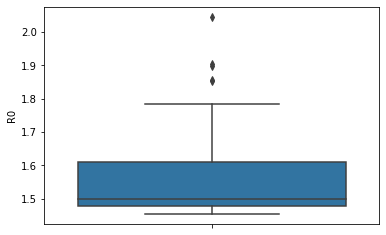

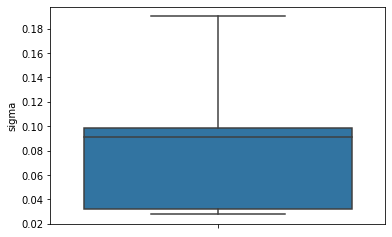

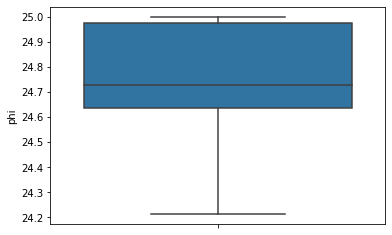

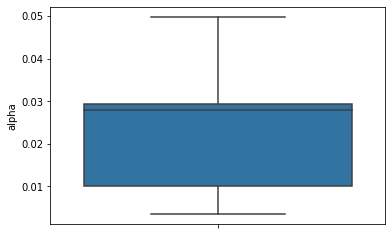

In [40]:
for parameter in ['R0', 'sigma', 'phi', 'alpha']:
  sns.boxplot(y=parameter, data=df_results)
  plt.show()

In [41]:
df_results.to_csv('data/modeling/experiments_estimated_parameters.csv', index=False)